# Part 1: Neural Networks Basics

## Introduction

In this part, you'll implement a simple neural network for EMNIST character recognition. This will help you understand the fundamentals of neural networks, including dense layers, activation functions, and dropout.

## Learning Objectives

- Load and preprocess EMNIST dataset
- Implement a simple neural network with dense layers
- Train and evaluate the model
- Save model and metrics in the correct format

## Setup and Installation

In [1]:
# Install required packages
%pip install -r /workspaces/6-neural-nets-nikita-gounder/.github/tests/requirements.txt

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_1', exist_ok=True)
os.makedirs('logs', exist_ok=True)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


2025-05-14 05:56:34.802687: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 05:56:35.025107: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 05:56:35.154731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747202195.290742   13669 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747202195.334196   13669 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747202195.707915   13669 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## 1. Data Loading and Preprocessing


In [12]:
#%pip install tensorflow_datasets
import tensorflow_datasets as tfds

emnist_dataset, emnist_info = tfds.load(
  'emnist/letters',
  split=['train', 'test'],
  as_supervised=True, # Returns tuple (img, label) instead of dict
  with_info=True, # Includes dataset metadata
)

ds_train, ds_test = emnist_dataset

#Convert train set
x_train, y_train = [], []
for image, label in tfds.as_numpy(ds_train):
    x_train.append(image)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

#Convert test set
x_test, y_test = [], []
for image, label in tfds.as_numpy(ds_test):
    x_test.append(image)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)


# Load EMNIST dataset
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.emnist.load_data('letters')

# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")


Training data shape: (88800, 28, 28, 1)
Test data shape: (14800, 28, 28, 1)
Number of classes: 26


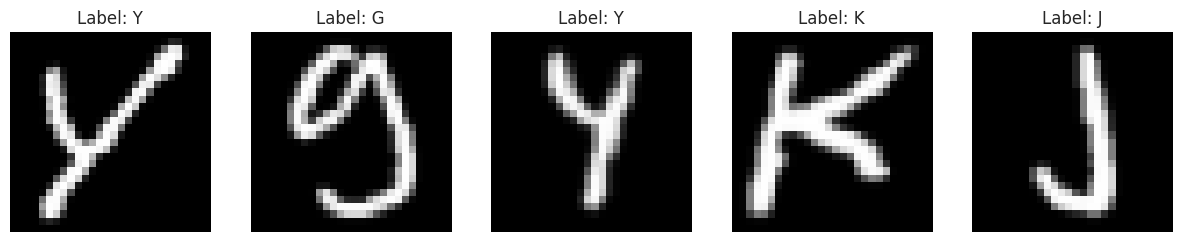

In [ ]:
# Plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.squeeze(x_train[i]).T, cmap='gray') #removes the 1 dimension that causes error
    plt.title(f'Label: {chr(y_train[i] + 64)}')
    plt.axis('off')
plt.show()

In [16]:
# Preprocess data

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for dense layers
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")


Preprocessed training data shape: (71040, 784)
Preprocessed validation data shape: (17760, 784)
Preprocessed test data shape: (14800, 784)


## 2. Model Implementation

In [ ]:
# Create simple neural network

def create_simple_nn(input_shape, num_classes):
    """
    Create a simple neural network for EMNIST classification.
    
    Requirements:
    - Must use at least 2 dense layers
    - Must include dropout layers
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 80% accuracy on test set
    - Minimize overfitting using dropout
    - Train efficiently with appropriate batch size
    
    Args:
        input_shape: Shape of input data (should be (784,) for flattened 28x28 images)
        num_classes: Number of output classes (26 for letters)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([...])
    
    model.compile(...)
    
    return model

# Create and compile model
model = create_simple_nn(input_shape=(784,), num_classes=26)
model.summary()

## 3. Training and Evaluation

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/emnist_classifier.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save metrics
metrics = {
    'model': 'emnist_classifier',
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_1/emnist_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")

## Progress Checkpoints

In .md file